In [ ]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz
%autoreload 2

from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *
from fastai2.callback.progress import *
from fastai2.callback.schedule import *
from fastai2.callback.rnn import *

## Input Only

In [ ]:
f_paths = '/mnt/Data/Systemidentification/WienerHammerstein/'
hdf_files = L([f for f in get_hdf_files(f_paths) if 'test' not in str(f)])

seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u'],TensorSequencesInput),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput)),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=200,stp_sz=20,clm='u')]),
                 splitter=FuncSplitter(lambda o: 'valid' in str(o['path']) ))

db = seq.databunch(hdf_files,batch_tfms=[to_cpu])

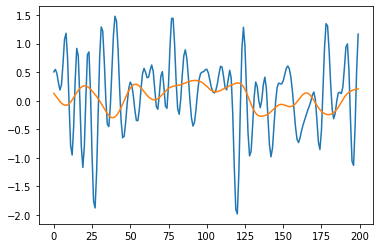

In [ ]:
db.show_batch(max_n=1)

In [ ]:
# model = SimpleGRU(1,1,num_layers=1,hidden_size=200)
# model = SimpleQRNN(1,1,hidden_size=20,n_layers=10,window=2)
# model = TCN(1,1,hl_depth=6,hl_width=5)
# model = ConvGRU(1,1,num_ft=20,num_cnn_layers=6)
model = ConvQRNN(1,1,num_ft=20,num_cnn_layers=6)

In [ ]:
skip = partial(SkipNLoss,n_skip=50)
lrn = Learner(db,model,loss_func=skip(nn.MSELoss()),opt_func=ranger,metrics=[skip(fun_rmse)])

In [ ]:
lrn.fit_one_cycle(10,lr_max=3e-2,pct_start=0.05)

In [ ]:
lrn.show_results(ds_idx=1,max_n=5)

## ProDiag

In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput,clm_shift=[-1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=200,stp_sz=20,clm='u')]),
                 splitter=FuncSplitter(lambda o: 'valid' in str(o['path']) ))
db = seq.databunch(hdf_files)

In [ ]:
model = ProgDiag_GRU(2,1,50)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(50),opt_func=ranger,metrics=fun_rmse)

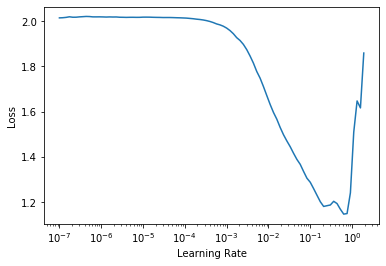

In [ ]:
lrn.lr_find()

In [ ]:
lrn.fit_one_cycle(10,lr_max=3e-3,pct_start=0.05)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.000107,0.000082,0.008417,00:17
1,0.000088,0.000058,0.007100,00:17
2,0.000086,0.000056,0.006788,00:17
3,0.000060,0.000043,0.006147,00:17
4,0.000048,0.000051,0.006709,00:16
5,0.000041,0.000038,0.005839,00:17
6,0.000037,0.000036,0.005671,00:17
7,0.000033,0.000034,0.005566,00:16
8,0.000032,0.000033,0.005499,00:17
9,0.000033,0.000033,0.005490,00:16


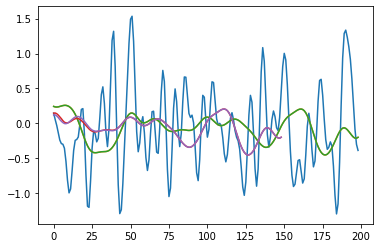

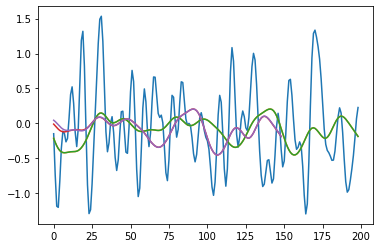

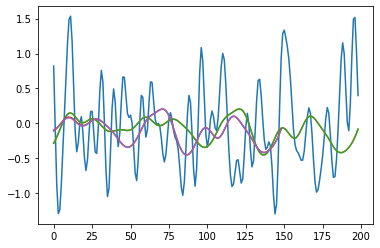

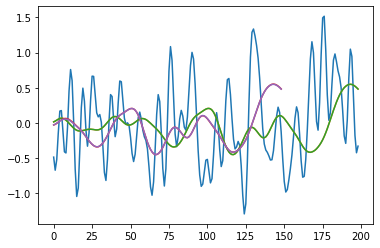

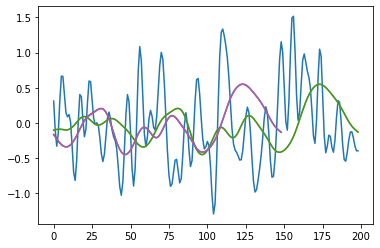

In [ ]:
lrn.show_results(ds_idx=1,max_n=5)

## Test

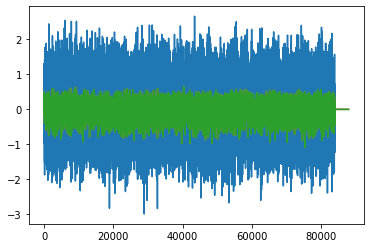

In [ ]:
f_tst = hdf_files = L([f for f in get_hdf_files(f_paths) if 'test' in str(f)])
db_tst = (DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput,clm_shift=[-1])),
                     splitter=IndexSplitter(None))
            .databunch(f_tst,bs=1))
db_tst.show_batch(max_n=1)

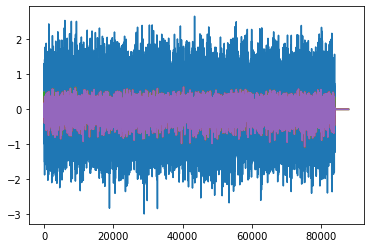

In [ ]:
lrn.show_results(dl=db_tst.train_dl)

In [ ]:
lrn.validate(dl=db_tst.train_dl)

(#2) [8.280539987026714e-06,0.00274187745526433]